#### Data Loader

In [118]:
import numpy as np 
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder

class PrevPdayTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def discretize_pdays(self, pdays):
        if pdays < 30:
            return pdays + 1
        if pdays == 999:
            return 0
        if pdays < 999:
            return 31
        if pdays > 999:
            return 32
        
    def discretize_previous(self, previous):
        if previous < 10:
            return previous
        else:
            return 10
        
    def transform(self, X):
        X['pdays'] = X['pdays'].apply(self.discretize_pdays)
        X['previous'] = X['previous'].apply(self.discretize_previous)
        return X
    
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

class EngineerFeatures():
    def __init__(self):
        self.num_pipeline_1 = Pipeline([
            ('prev_n_pday', PrevPdayTransformer()),
            ('log_transform', FunctionTransformer(np.log1p, validate=True)),
            ('std_scaler', StandardScaler()),
        ])
        
        self.num_pipeline_2 = Pipeline([
            ('std_scaler', StandardScaler()),
        ])
        
    def transform(self, df):
        # drop column 'default' and get the target variable 
        Y = df['y']
        X_df = df.drop(['default', 'y'], axis=1)
        
        # separate the numerical and categorical columns names 
        num_df_cols = X_df.select_dtypes(include=['int64', 'float64']).columns
        cat_df_cols = X_df.select_dtypes(include=['object']).columns
        num_pipeline_1_cols = ['duration', 'campaign', 'pdays', 'previous']
        num_pipeline_2_cols = list(set(num_df_cols) - set(num_pipeline_1_cols))
        
        # define the full pipeline
        full_pipeline = ColumnTransformer([
            ('num1', self.num_pipeline_1, num_pipeline_1_cols),
            ('num2', self.num_pipeline_2, num_pipeline_2_cols),
            ('one-hot-encoder', OneHotEncoder(), cat_df_cols),
        ])
        
        # Label encoding the target variable
        Y = Y.map({'no': 1, 'yes': 0})
        X = full_pipeline.fit_transform(X_df)
        
        return X, Y, full_pipeline

#### Evaluation calc functions

In [119]:
import matplotlib.pyplot as plt

def get_alift_score(Y, Y_pred, Y_prob, target_index=0, num_bins=20):
    bins = np.linspace(0, 1, num_bins)
    Y_prob_target = Y_prob[:, target_index]
    Y_mat = np.vstack((Y, Y_pred, Y_prob_target)).T
    Y_df = pd.DataFrame(Y_mat, columns=['Y', 'Y_pred', 'Y_prob'])
    Y_df['bin'] = np.digitize(Y_df['Y_prob'], bins)
    avg_lift = Y_df[Y_df['Y'] == target_index].shape[0]
    #lift_score = Y_df.groupby('bin').apply(lambda x: x[x['Y'] == target_index].shape[0] / x.shape[0] / avg_lift).values
    lift_scores = []
    for bin in bins:
        lift_score = Y_df[Y_df['Y_prob'] < bin]
        lift_scores.append(lift_score.shape[0]/ Y_df.shape[0])
    
    # plot the lift curve    
    plt.plot(bins, lift_scores)
    plt.xlabel('amount of data')
    plt.ylabel('lift score')
    plt.title('Lift curve')
    plt.show()
    
    # get the area under the lift curve
    auc_score = np.trapz(lift_scores, bins)
    return auc_score

In [120]:
import tensorflow as tf 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import os

def evaluation_metrics(Y, Y_pred, Y_prob, save_plots_dir=None):
    tp, fn, fp, tn = confusion_matrix(Y, Y_pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1 = 2 * precision * recall / (precision + recall)
    accuracy = (tp + tn) / (tp + fn + fp + tn)
    AUC = roc_auc_score(Y, Y_prob[:, 1])
    
    print("||>> Precision: ", precision)
    print("||>> Recall: ", recall)
    print("||>> F1: ", f1)
    print("||>> Accuracy: ", accuracy)
    print("||>> AUC: ", AUC)
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(Y, Y_prob[:, 1])
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC Curve')
    if save_plots_dir:
        plt.savefig(os.path.join(save_plots_dir, 'roc_curve.png'))
    else:
        plt.show()
    
    # Precision-Recall curve
    precisions, recalls, thresholds = precision_recall_curve(Y, Y_prob[:, 0], pos_label=0)
    plt.cla()
    plt.plot(recalls, precisions)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall curve') 
    if save_plots_dir:
        plt.savefig(os.path.join(save_plots_dir, 'precision_recall_curve.png'))
    else:
        plt.show()
    
    AUPRC = auc(recalls, precisions)
    print("||>> AUPRC: ", AUPRC)
    
    return precision, recall, f1, accuracy, AUC, AUPRC

#### Calculate

#### NN Model

In [124]:
import tensorflow as tf

# Load the TensorFlow model
#model = tf.keras.models.load_model('../mount/trained_models/NN_balaced_1/model.keras')
model = tf.keras.models.load_model('../mount/trained_models/NN_1/model.keras')

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,236 (141.55 KB)

 Trainable params: 12,078 (47.18 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,158 (94.37 KB)

In [125]:
import pandas as pd 

df = pd.read_csv('../mount/Data_Manipulation_datasets/test.csv')
feature_engineer = EngineerFeatures()
X, Y, _ = feature_engineer.transform(df)

Y_prob = model.predict(X)
Y_pred = np.argmax(Y_prob, axis=1)

258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


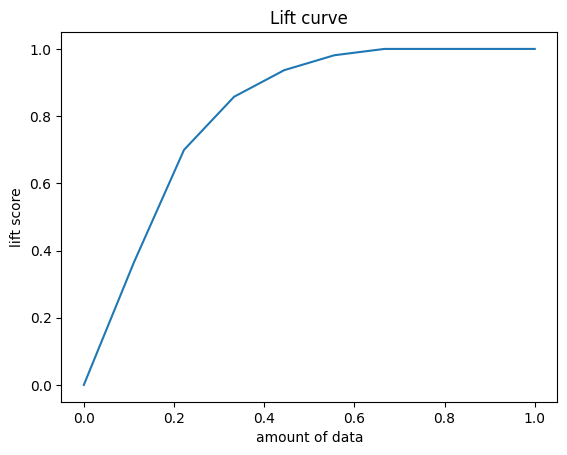

ALIFT score: 0.8155523177378448


In [126]:
auc_score = get_alift_score(Y, Y_pred, Y_prob, target_index=0, num_bins=10)
print(f"ALIFT score: {auc_score}")

||>> Precision:  0.6466876971608833
||>> Recall:  0.21112255406797117
||>> F1:  0.3183229813664596
||>> Accuracy:  0.8933948518698397
||>> AUC:  0.8671876716591194


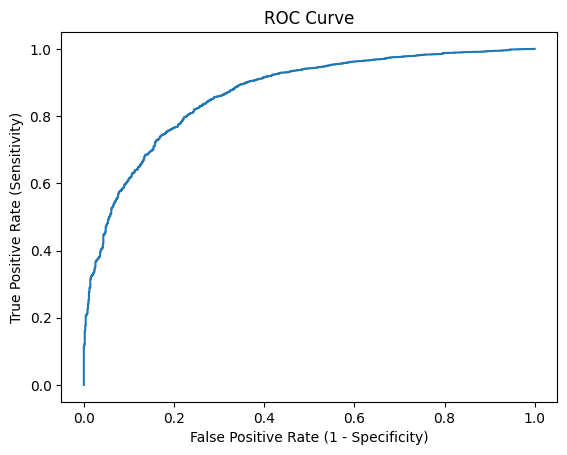

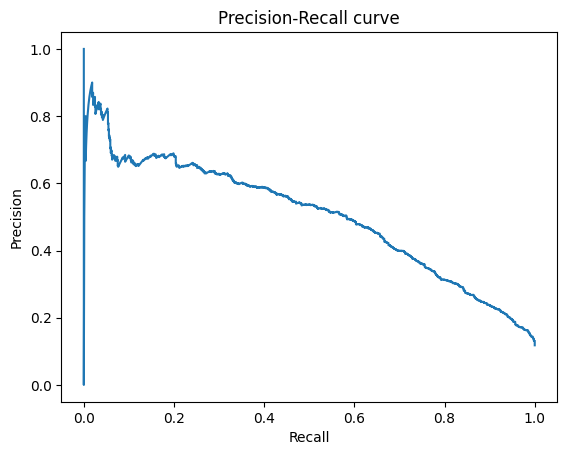

||>> AUPRC:  0.501732188911779


In [127]:
precision, recall, f1, accuracy, AUC, AUPRC = evaluation_metrics(Y, Y_pred, Y_prob)

#### NN Model (balanced dataset)

In [129]:
import tensorflow as tf

# Load the TensorFlow model
model = tf.keras.models.load_model('../mount/trained_models/NN_balanced_1/best_model.keras')
#model = tf.keras.models.load_model('../mount/trained_models/NN_1/model.keras')

# Print the model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │         7,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 4)              │           132 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            10 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,236 (141.55 KB)

 Trainable params: 12,078 (47.18 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 24,158 (94.37 KB)

In [130]:
import pandas as pd 

df = pd.read_csv('../mount/Data_Manipulation_datasets/test.csv')
feature_engineer = EngineerFeatures()
X, Y, _ = feature_engineer.transform(df)

Y_prob = model.predict(X)
Y_pred = np.argmax(Y_prob, axis=1)

258/258 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


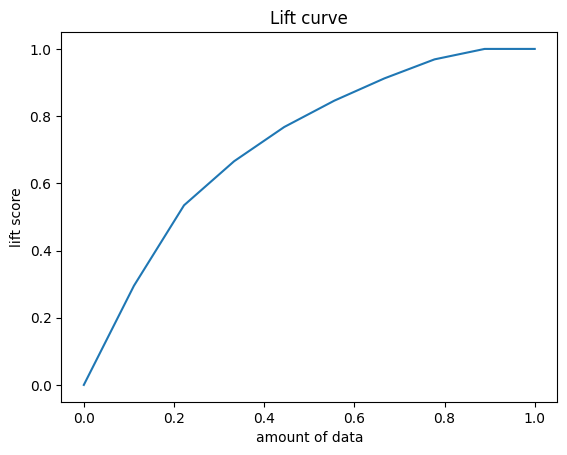

ALIFT score: 0.7211429496519346


In [131]:
auc_score = get_alift_score(Y, Y_pred, Y_prob, target_index=0, num_bins=10)
print(f"ALIFT score: {auc_score}")

||>> Precision:  0.417617237008872
||>> Recall:  0.678681771369722
||>> F1:  0.5170655158885837
||>> Accuracy:  0.8505342399222924
||>> AUC:  0.8623669342806495


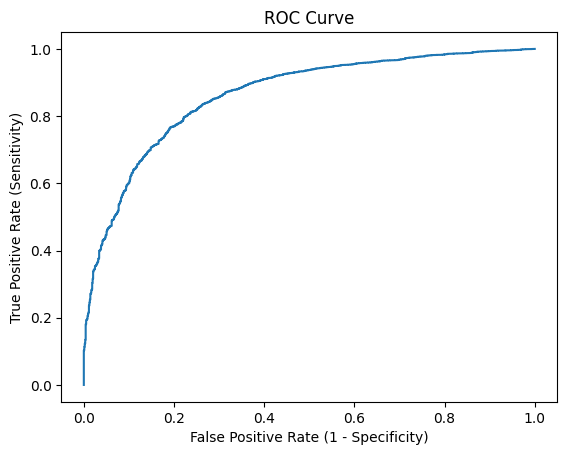

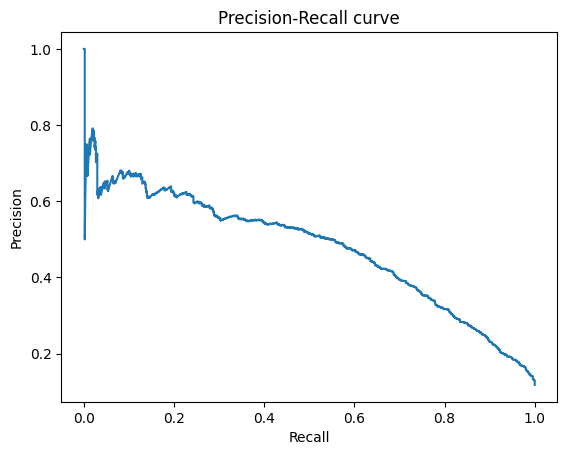

||>> AUPRC:  0.47555794641296645


In [132]:
precision, recall, f1, accuracy, AUC, AUPRC = evaluation_metrics(Y, Y_pred, Y_prob)